# Chapter 10. 회귀 분석으로 연속적 타깃 변수 예측

## 10.2 주택 데이터셋 탐색

In [8]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


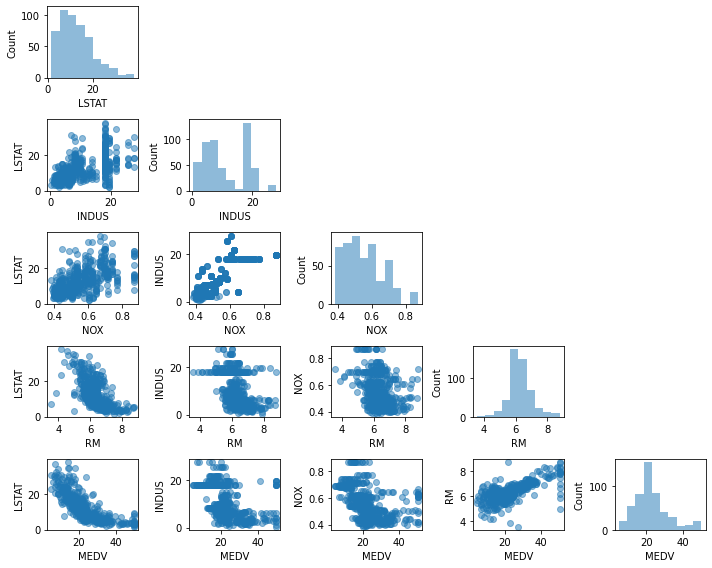

In [9]:
# install MLxtend library
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10, 8),
                  names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

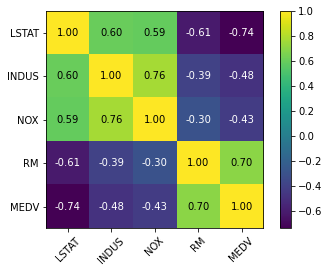

In [10]:
from mlxtend.plotting import heatmap
import numpy as np
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm,
             row_names=cols,
             column_names=cols)
plt.show()